## Calibration methodology plots 

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

### Coners detection visualisation with different window size 

In [15]:
def detect_chessboard(frame, winSize=(5, 5)):
    pattern_size = (9, 6)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.001)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size)
    if ret:
        corners = cv2.cornerSubPix(gray, corners, winSize, (-1, -1), criteria)

    return ret, corners


chessboard_size = (9, 6)
square_size_mm = 60
cam_1_frames = f"{root}/images/STEREOS/STEREO_A/CAMERA_1/intrinsic_frames"
output_folder = f"{root}/report/corner_detections_draw"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
else:
    shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

param_variants = [
    {'winSize': (5, 5), 'color': (0, 255, 0)},    # Green
    {'winSize': (15, 15), 'color': (0, 0, 255)}  # Red
]

images = glob.glob(os.path.join(cam_1_frames, "*.png"))
for frame in images:
    img = cv2.imread(frame)
    filename = os.path.basename(frame)
    
    for params in param_variants:
        img_draw = img.copy()  # Fresh copy for each color
        ret, corners = detect_chessboard(img, winSize=params['winSize'])
        if ret:
            for corner in corners:
                img_draw = cv2.drawChessboardCorners(
                    img_draw, 
                    chessboard_size,
                    corners,
                    ret
                )
        
        color_folder = os.path.join(output_folder, 'green' if params['color'] == (0, 255, 0) else 'red')
        sub_folder = f"{output_folder}/{filename}"
        os.makedirs(sub_folder, exist_ok=True)
        color = 'green' if params['color'] == (0, 255, 0) else 'red'
        image_path = f"{sub_folder}/{color}.png"
        cv2.imwrite(image_path, img_draw)

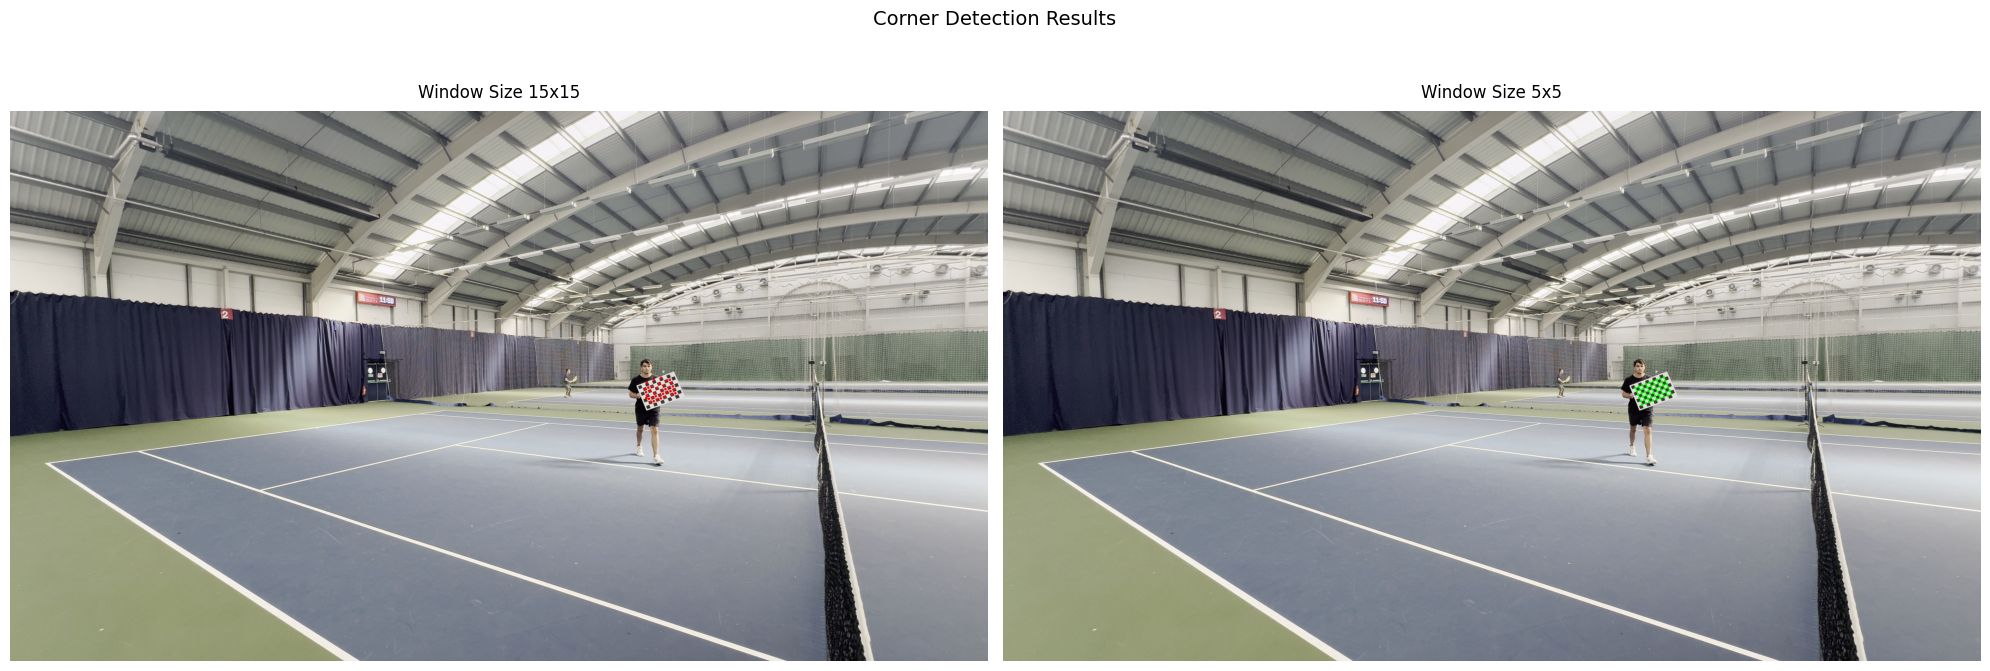

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the paths to the images
frame_folder = f"{root}/report/corner_detections_circles/frame_42.png"
green_img_path = os.path.join(frame_folder, "green.png")
red_img_path = os.path.join(frame_folder, "red.png")

# Read the images
green_img = mpimg.imread(green_img_path)
red_img = mpimg.imread(red_img_path)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(red_img)
ax1.set_title('Window Size 15x15', pad=10, fontsize=12)
ax1.axis('off')

# Plot the images
ax2.imshow(green_img)
ax2.set_title('Window Size 5x5', pad=10, fontsize=12)
ax2.axis('off')


# Add a main title
plt.suptitle('Corner Detection Results', y=0.95, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


### distorted vs undistorted

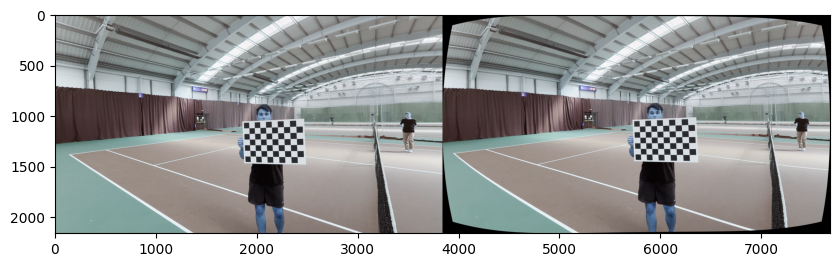

In [18]:
frame_example = f"{root}/images/STEREOS/STEREO_A/CAMERA_1/intrinsic_frames/frame_1.png"

intrinsics_path = f"{root}/output/V2_intrinsic_params.json"
with open(intrinsics_path, 'r') as f:
    intrinsic_params = json.load(f)
    
K_cam1 = np.array(intrinsic_params['CAM_1']['K'])
K_cam1_undistort = np.array(intrinsic_params['CAM_1']['K_undistort'])
D_cam1 = np.array(intrinsic_params['CAM_1']['D'])

img = cv2.imread(frame_example)

# Undistort using OpenCV
undistorted = cv2.undistort(img, K_cam1, D_cam1, None, K_cam1_undistort)

# Side-by-side comparison
comparison = cv2.hconcat([img, undistorted])

# print the image showing it big 
plt.figure(figsize=(10, 7))
plt.imshow(comparison)
plt.show()



### Calibration datasets

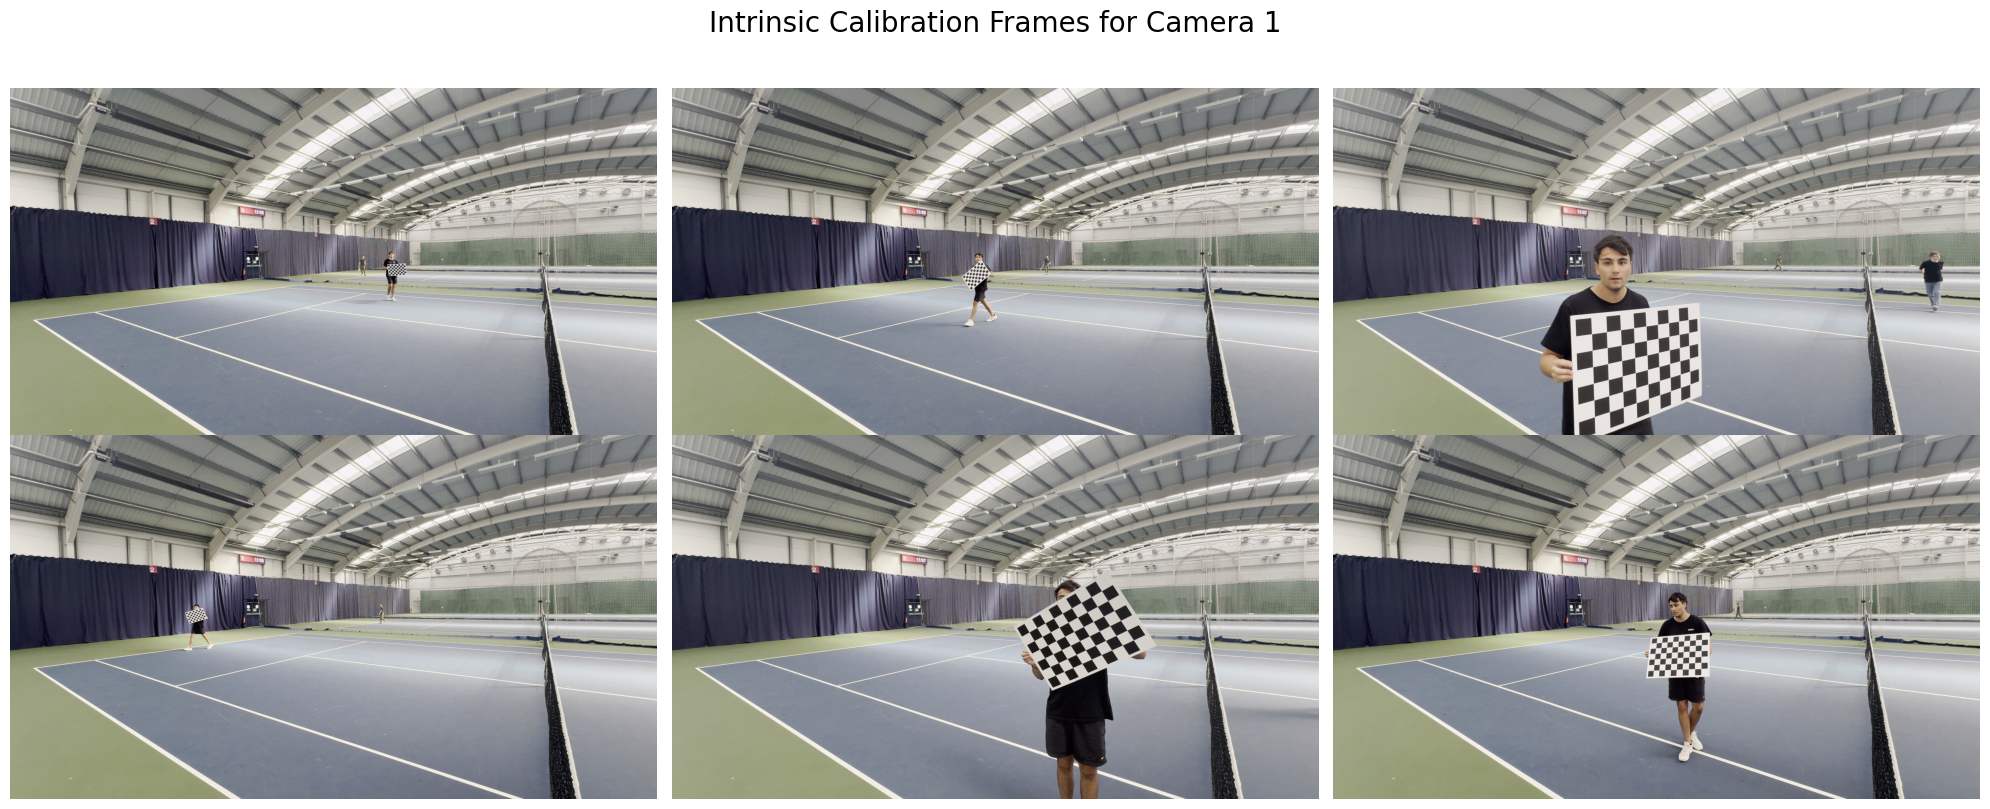

In [21]:
# i need to plot a sample of 6 frames from a dataset of frames
# need to be plotted as 2 rows of 3 frames each 
intrinsic_frames_folder = f"{root}/images/STEREOS/STEREO_A/CAMERA_1/intrinsic_frames"
save_path = f"{root}/images/STEREOS/STEREO_A/CAMERA_1/intrinsic_frames/calibration_frames.png"

def plot_intrinsic_frames(intrinsic_frames_folder, save_path=None):
    frames = glob.glob(f"{intrinsic_frames_folder}/*.png")
    frames = np.random.choice(frames, 6, replace=False)
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))
    plt.subplots_adjust(wspace=0, hspace=-0.8)
    
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2RGB)
        axs[i//3, i%3].imshow(frame)
        axs[i//3, i%3].axis('off')
    
    fig.suptitle('Intrinsic Calibration Frames for Camera 1', fontsize=20, y=0.75)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_intrinsic_frames(intrinsic_frames_folder)


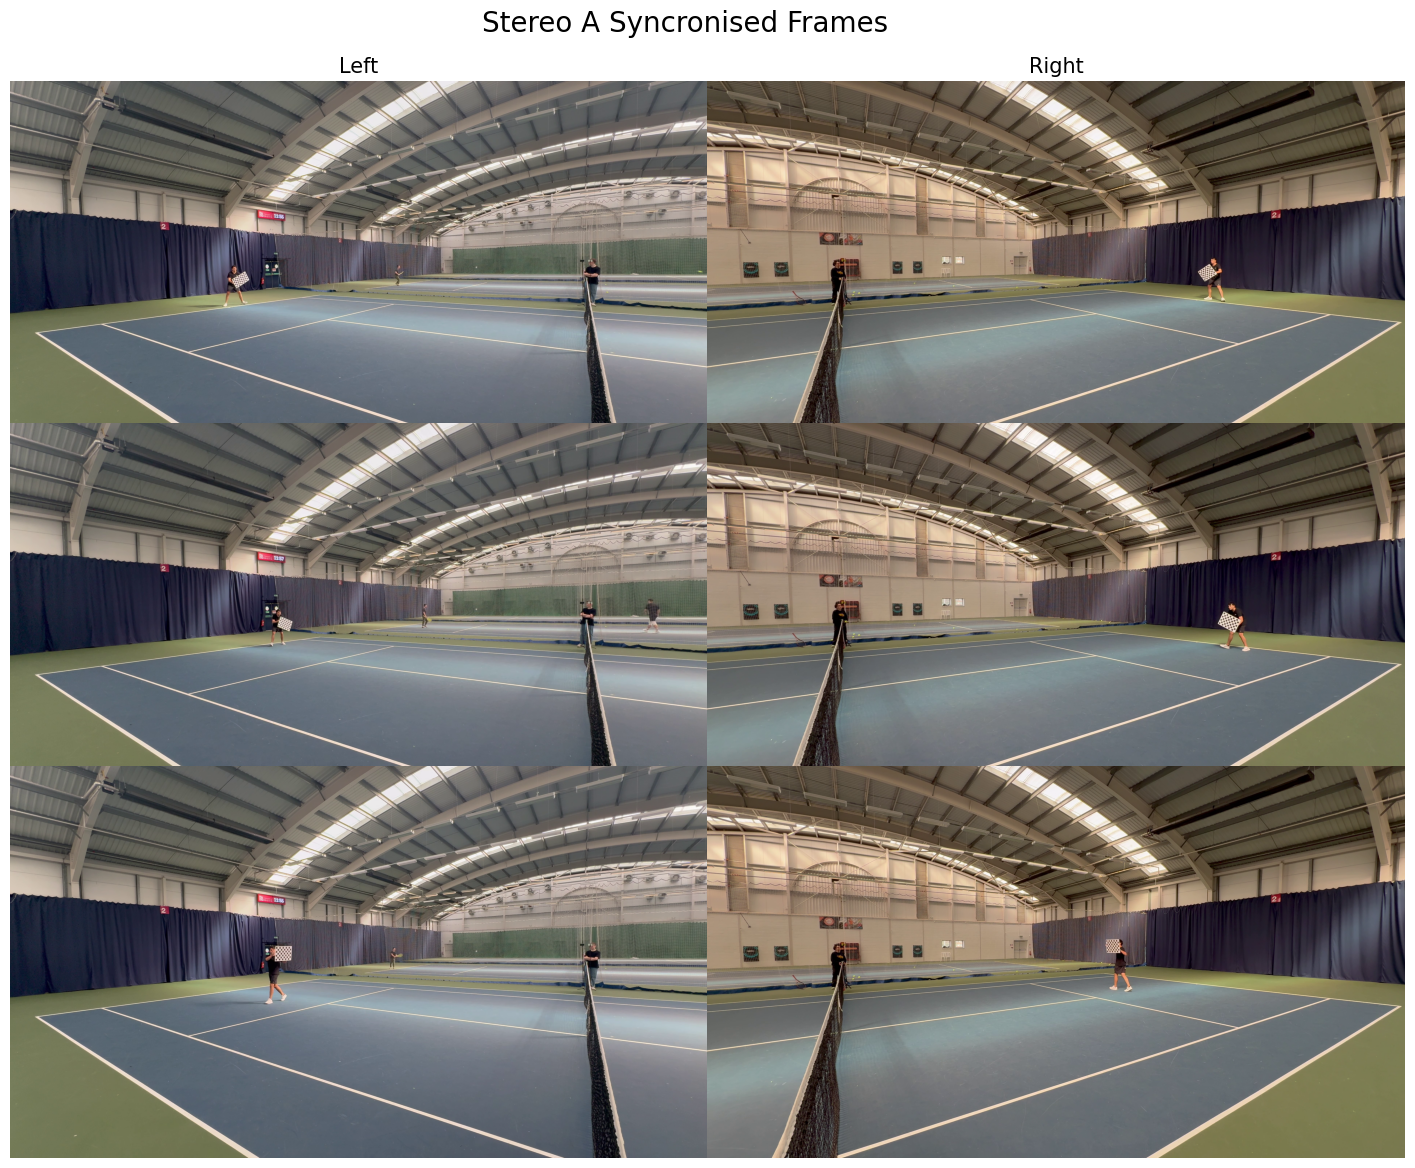

In [28]:
# inside stereo frames there are sub folders with frames from cam1 and cam2
extrinsic_frames_folder = f"{root}/images/STEREOS/STEREO_A/stereo_frames"

def plot_stereo_frames(extrinsic_frames_folder):
    subfolders = glob.glob(f"{extrinsic_frames_folder}/*")
    selected_folders = np.random.choice(subfolders, 3, replace=False)
    fig, axs = plt.subplots(3, 2, figsize=(18, 20))
    plt.subplots_adjust(wspace=0, hspace=-0.6)
    
    for i, folder in enumerate(selected_folders):
        # where plotting left put subtitle left and right for the other plot subtitle right
        if i == 0:
            axs[i, 0].set_title('Left', fontsize=15)
            axs[i, 1].set_title('Right', fontsize=15)
        else:
            axs[i, 0].set_title('')
            axs[i, 1].set_title('')
        
        frame1 = cv2.cvtColor(cv2.imread(f"{folder}/cam_1.png"), cv2.COLOR_BGR2RGB)
        frame2 = cv2.cvtColor(cv2.imread(f"{folder}/cam_2.png"), cv2.COLOR_BGR2RGB)
        
        axs[i, 0].imshow(frame1)
        axs[i, 1].imshow(frame2)
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    
    fig.suptitle('Stereo A Syncronised Frames', fontsize=20, y=0.8)
    plt.show()

plot_stereo_frames(extrinsic_frames_folder)
